# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
import json
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Preprocessing

In [2]:
# --- 1. Data Loading and Initial Preprocessing ---

# Define consistent figure size for initial visualization
plt.rcParams["figure.figsize"] = (12, 6)

sheets_to_load = [
    'Accelerometer',
    'Gyroscope',
    'Orientation',
    'Gravity'
 ]

straight_folder_path = 'Data/Train/Straight'
straight_excel_file_path = [os.path.join(straight_folder_path, f) for f in os.listdir(straight_folder_path) if (f.endswith('.xls') or f.endswith('.xlsx'))]

slouch_folder_path = 'Data/Train/Slouch'
slouch_excel_file_path = [os.path.join(slouch_folder_path, f) for f in os.listdir(slouch_folder_path) if (f.endswith('.xls') or f.endswith('.xlsx'))]

leanback_folder_path = 'Data/Train/LeanBack'
leanback_excel_file_path = [os.path.join(leanback_folder_path, f) for f in os.listdir(leanback_folder_path) if (f.endswith('.xls') or f.endswith('.xlsx'))]

leanleft_folder_path = 'Data/Train/LeanLeft'
leanleft_excel_file_path = [os.path.join(leanleft_folder_path, f) for f in os.listdir(leanleft_folder_path) if (f.endswith('.xls') or f.endswith('.xlsx'))]

leanright_folder_path = 'Data/Train/LeanRight'
leanright_excel_file_path = [os.path.join(leanright_folder_path, f) for f in os.listdir(leanright_folder_path) if (f.endswith('.xls') or f.endswith('.xlsx'))]

# Define common time column name
TIME_COL = 'Time (s)'

# Preprocessing function
def preprocess_sensor_data(excel_file_path, sheet_names):
    processed_dataframes = {}
    interval = 0.1
    trim_seconds = 3

    for sheet_name in sheet_names:
        df = pd.read_excel(excel_file_path, sheet_name=sheet_name)

        if not df.empty and TIME_COL in df.columns:
            df_min_time = df[TIME_COL].min()
            df_max_time = df[TIME_COL].max()
            start_time = df_min_time + trim_seconds
            end_time = df_max_time - trim_seconds
            if start_time < end_time:
                df = df[(df[TIME_COL] >= start_time) & (df[TIME_COL] <= end_time)]

        if df.empty:
            continue

        if sheet_name == 'Orientation':
            df.dropna(inplace=True)

        df_copy = df.copy()
        df_copy['Time_Bucket'] = (df_copy[TIME_COL] / interval).round() * interval
        sensor_cols = [col for col in df_copy.columns if col not in [TIME_COL, 'Time_Bucket']]
        bucketed_df = df_copy.groupby('Time_Bucket')[sensor_cols].mean().reset_index()

        cleaned_sheet_name = 'df_' + sheet_name.replace(' ', '_').lower()
        processed_dataframes[cleaned_sheet_name + '_bucketed'] = bucketed_df

    magnitude_configs = {
        'df_accelerometer_bucketed': {
            'columns': ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'],
            'magnitude_col': 'accelerometer_magnitude'
        },
        'df_gyroscope_bucketed': {
            'columns': ['Gyroscope x (rad/s)', 'Gyroscope y (rad/s)', 'Gyroscope z (rad/s)'],
            'magnitude_col': 'gyroscope_magnitude'
        },
        'df_gravity_bucketed': {
            'columns': ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'],
            'magnitude_col': 'gravity_magnitude'
        }
    }

    for df_key, config in magnitude_configs.items():
        if df_key in processed_dataframes:
            df = processed_dataframes[df_key]
            x_col, y_col, z_col = config['columns']
            magnitude_col = config['magnitude_col']
            if all(col in df.columns for col in [x_col, y_col, z_col]):
                df[magnitude_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)

    return processed_dataframes

def aggregate_processed_dataframes(list_of_processed_dicts):
    if not list_of_processed_dicts:
        return {}

    aggregated_dataframes = {}
    # Get all unique keys (df names) from the first dictionary to initialize
    for key in list_of_processed_dicts[0].keys():
        # Collect all dataframes for the current key from all dictionaries
        dfs_for_key = [d[key] for d in list_of_processed_dicts if key in d]
        if dfs_for_key:
            # Concatenate them into a single dataframe
            aggregated_dataframes[key] = pd.concat(dfs_for_key, ignore_index=True)
            # Ensure time buckets are unique and sorted after concatenation
            if 'Time_Bucket' in aggregated_dataframes[key].columns:
                aggregated_dataframes[key].sort_values(by='Time_Bucket', inplace=True)
                aggregated_dataframes[key].reset_index(drop=True, inplace=True)
    return aggregated_dataframes

# Process all data files for straight posture
all_straight_processed_data = []
for file_path in straight_excel_file_path:
    all_straight_processed_data.append(preprocess_sensor_data(file_path, sheets_to_load))
bucketed_dataframes_straight = aggregate_processed_dataframes(all_straight_processed_data)

# Process all data files for slouch posture
all_slouch_processed_data = []
for file_path in slouch_excel_file_path:
    all_slouch_processed_data.append(preprocess_sensor_data(file_path, sheets_to_load))
bucketed_dataframes_slouch = aggregate_processed_dataframes(all_slouch_processed_data)

# Process all data files for leanback posture
all_leanback_processed_data = []
for file_path in leanback_excel_file_path:
    all_leanback_processed_data.append(preprocess_sensor_data(file_path, sheets_to_load))
bucketed_dataframes_leanback = aggregate_processed_dataframes(all_leanback_processed_data)

# Process all data files for leanleft posture
all_leanleft_processed_data = []
for file_path in leanleft_excel_file_path:
    all_leanleft_processed_data.append(preprocess_sensor_data(file_path, sheets_to_load))
bucketed_dataframes_leanleft = aggregate_processed_dataframes(all_leanleft_processed_data)

# Process all data files for leanright posture
all_leanright_processed_data = []
for file_path in leanright_excel_file_path:
    all_leanright_processed_data.append(preprocess_sensor_data(file_path, sheets_to_load))
bucketed_dataframes_leanright = aggregate_processed_dataframes(all_leanright_processed_data)

# Viz

### Visualizing Accelerometer X, Y, Z Components Over Time (Straight vs. Slouch)

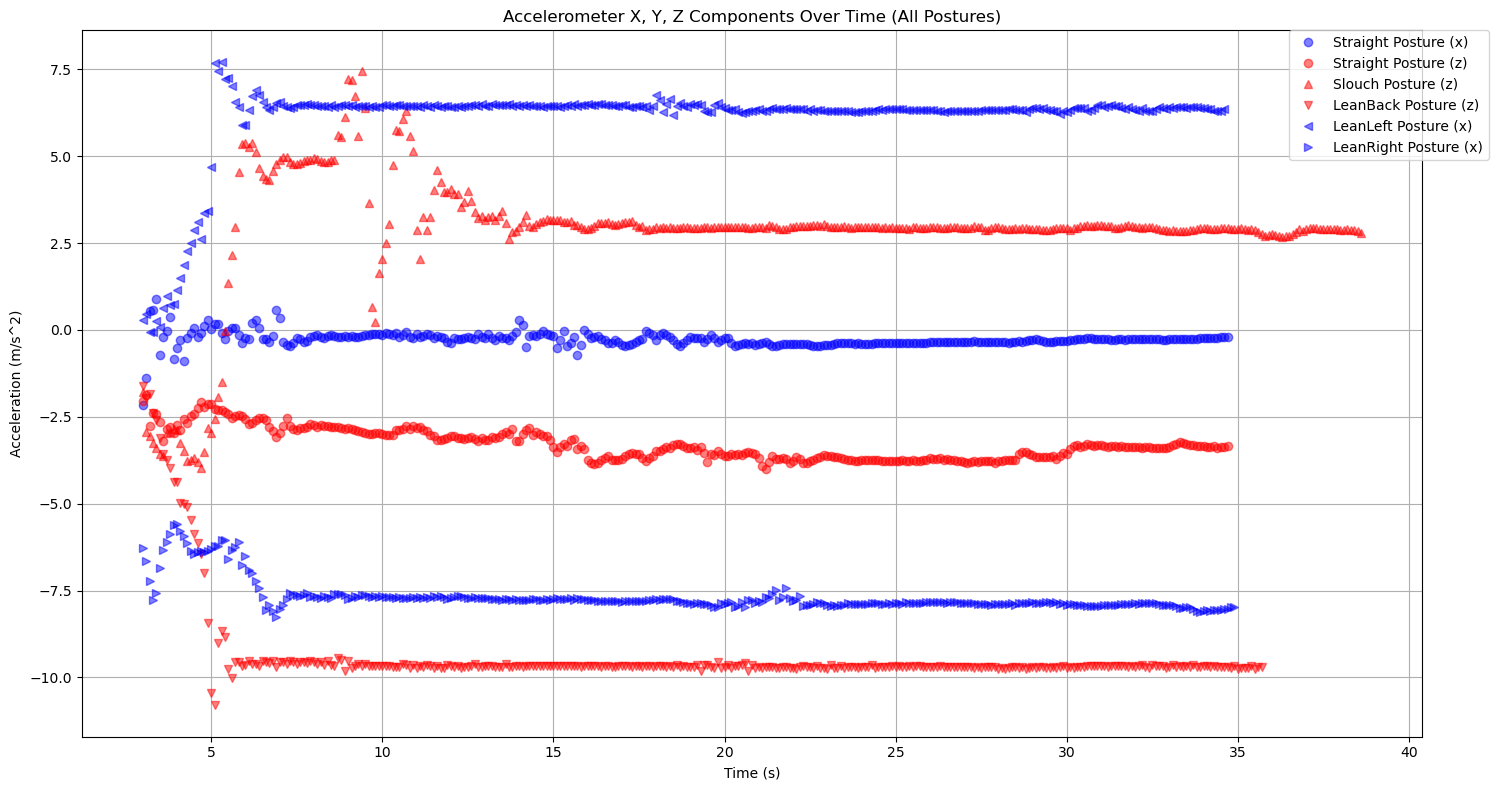

In [4]:
plt.figure(figsize=(15, 8))

lines = []
labels = []

accel_cols = ['Acceleration x (m/s^2)',  'Acceleration z (m/s^2)']
colors = ['blue', 'red', 'green']

linestyles = {
    'straight': 'o',
    'slouch': '^',
    'leanback': 'v',
    'leanleft': '<',
    'leanright': '>'
}

# Plot for Straight Posture Accelerometer components
if 'df_accelerometer_bucketed' in bucketed_dataframes_straight:
    df_straight_accel = bucketed_dataframes_straight['df_accelerometer_bucketed']
    for i, col in enumerate(accel_cols):
        if col in df_straight_accel.columns and not df_straight_accel[col].empty:
            line, = plt.plot(df_straight_accel['Time_Bucket'], df_straight_accel[col], label=f'Straight Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['straight'], linestyle='None')
            lines.append(line)
            labels.append(f'Straight Posture ({col.split(" ")[1]})')

# Plot for Slouch Posture Accelerometer components
if 'df_accelerometer_bucketed' in bucketed_dataframes_slouch:
    df_slouch_accel = bucketed_dataframes_slouch['df_accelerometer_bucketed']
    for i, col in enumerate(accel_cols):
        if col == 'Acceleration x (m/s^2)':
            continue
        if col in df_slouch_accel.columns and not df_slouch_accel[col].empty:
            line, = plt.plot(df_slouch_accel['Time_Bucket'], df_slouch_accel[col], label=f'Slouch Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['slouch'], linestyle='None')
            lines.append(line)
            labels.append(f'Slouch Posture ({col.split(" ")[1]})')

# Plot for LeanBack Posture Accelerometer components
if 'df_accelerometer_bucketed' in bucketed_dataframes_leanback:
    df_leanback_accel = bucketed_dataframes_leanback['df_accelerometer_bucketed']
    for i, col in enumerate(accel_cols):
        if col == 'Acceleration x (m/s^2)':
            continue
        if col in df_leanback_accel.columns and not df_leanback_accel[col].empty:
            line, = plt.plot(df_leanback_accel['Time_Bucket'], df_leanback_accel[col], label=f'LeanBack Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['leanback'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanBack Posture ({col.split(" ")[1]})')

# Plot for LeanLeft Posture Accelerometer components
if 'df_accelerometer_bucketed' in bucketed_dataframes_leanleft:
    df_leanleft_accel = bucketed_dataframes_leanleft['df_accelerometer_bucketed']
    for i, col in enumerate(accel_cols):
        if col == 'Acceleration y (m/s^2)' or col == 'Acceleration z (m/s^2)':
            continue
        if col in df_leanleft_accel.columns and not df_leanleft_accel[col].empty:
            line, = plt.plot(df_leanleft_accel['Time_Bucket'], df_leanleft_accel[col], label=f'LeanLeft Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['leanleft'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanLeft Posture ({col.split(" ")[1]})')

# Plot for LeanRight Posture Accelerometer components
if 'df_accelerometer_bucketed' in bucketed_dataframes_leanright:
    df_leanright_accel = bucketed_dataframes_leanright['df_accelerometer_bucketed']
    for i, col in enumerate(accel_cols):
        if col == 'Acceleration y (m/s^2)' or col == 'Acceleration z (m/s^2)':
            continue
        if col in df_leanright_accel.columns and not df_leanright_accel[col].empty:
            line, = plt.plot(df_leanright_accel['Time_Bucket'], df_leanright_accel[col], label=f'LeanRight Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['leanright'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanRight Posture ({col.split(" ")[1]})')

plt.title('Accelerometer X, Y, Z Components Over Time (All Postures)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
if lines:
    plt.legend(lines, labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.) # Adjust legend position
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing Gyroscope X, Y, Z Components Over Time (Straight vs. Slouch)

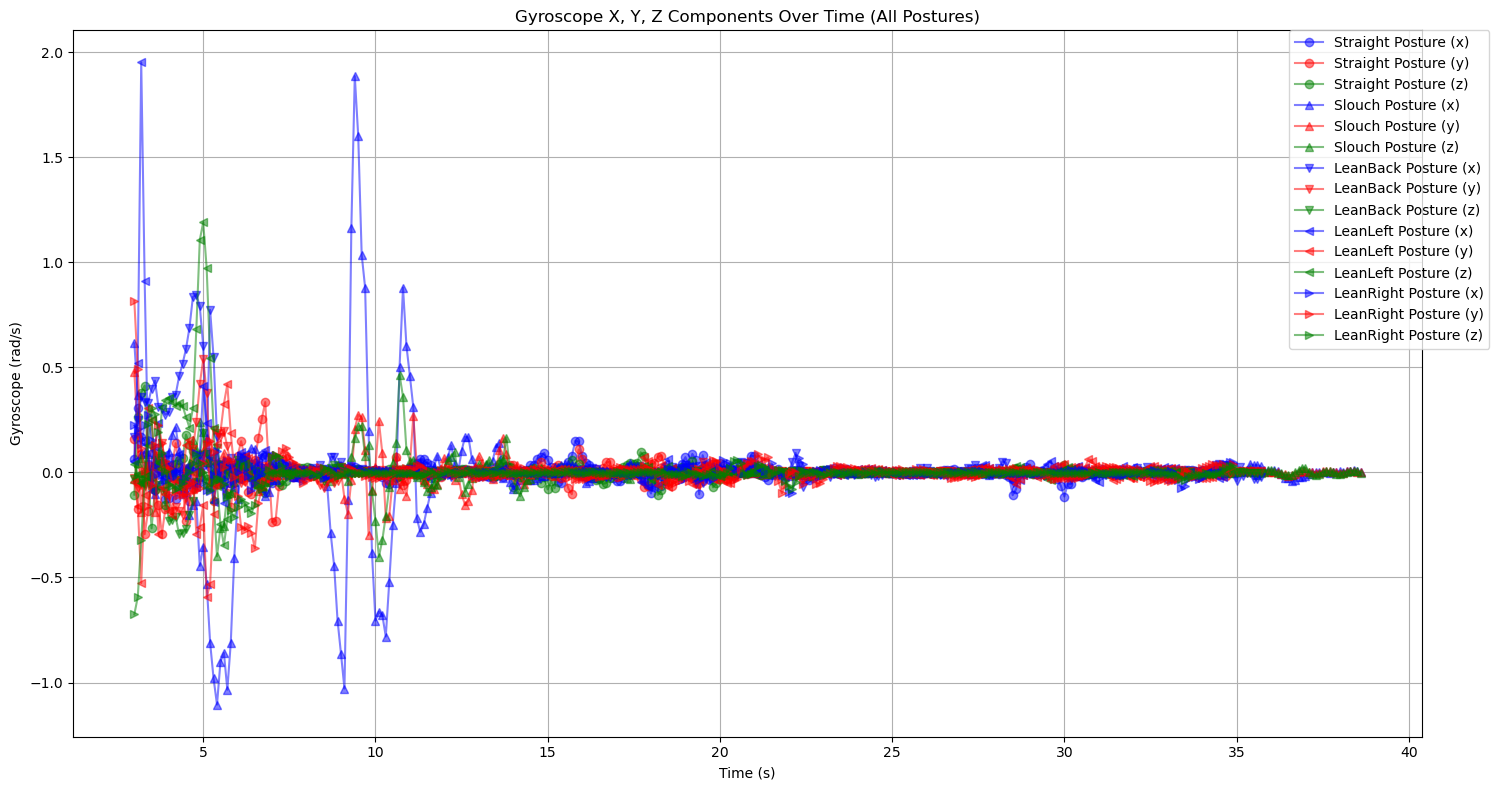

In [5]:

plt.figure(figsize=(15, 8))

lines = []
labels = []

gyro_cols = ['Gyroscope x (rad/s)', 'Gyroscope y (rad/s)', 'Gyroscope z (rad/s)']
colors = ['blue', 'red', 'green'] # Single set of colors for components

linestyles = {
    'straight': 'o',
    'slouch': '^',
    'leanback': 'v',
    'leanleft': '<',
    'leanright': '>'
}

# Plot for Straight Posture Gyroscope components
if 'df_gyroscope_bucketed' in bucketed_dataframes_straight:
    df_straight_gyro = bucketed_dataframes_straight['df_gyroscope_bucketed']
    for i, col in enumerate(gyro_cols):

        if col in df_straight_gyro.columns and not df_straight_gyro[col].empty:
            line_straight, = plt.plot(df_straight_gyro['Time_Bucket'], df_straight_gyro[col], label=f'Straight Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['straight'])
            lines.append(line_straight)
            labels.append(f'Straight Posture ({col.split(" ")[1]})')

# Plot for Slouch Posture Gyroscope components
if 'df_gyroscope_bucketed' in bucketed_dataframes_slouch:
    df_slouch_gyro = bucketed_dataframes_slouch['df_gyroscope_bucketed']
    for i, col in enumerate(gyro_cols):
        if col in df_slouch_gyro.columns and not df_slouch_gyro[col].empty:
            line_slouch, = plt.plot(df_slouch_gyro['Time_Bucket'], df_slouch_gyro[col], label=f'Slouch Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['slouch'])
            lines.append(line_slouch)
            labels.append(f'Slouch Posture ({col.split(" ")[1]})')

# Plot for LeanBack Posture Gyroscope components
if 'df_gyroscope_bucketed' in bucketed_dataframes_leanback:
    df_leanback_gyro = bucketed_dataframes_leanback['df_gyroscope_bucketed']
    for i, col in enumerate(gyro_cols):
        if col in df_leanback_gyro.columns and not df_leanback_gyro[col].empty:
            line, = plt.plot(df_leanback_gyro['Time_Bucket'], df_leanback_gyro[col], label=f'LeanBack Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['leanback'])
            lines.append(line)
            labels.append(f'LeanBack Posture ({col.split(" ")[1]})')

# Plot for LeanLeft Posture Gyroscope components
if 'df_gyroscope_bucketed' in bucketed_dataframes_leanleft:
    df_leanleft_gyro = bucketed_dataframes_leanleft['df_gyroscope_bucketed']
    for i, col in enumerate(gyro_cols):
        if col in df_leanleft_gyro.columns and not df_leanleft_gyro[col].empty:
            line, = plt.plot(df_leanleft_gyro['Time_Bucket'], df_leanleft_gyro[col], label=f'LeanLeft Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['leanleft'])
            lines.append(line)
            labels.append(f'LeanLeft Posture ({col.split(" ")[1]})')

# Plot for LeanRight Posture Gyroscope components
if 'df_gyroscope_bucketed' in bucketed_dataframes_leanright:
    df_leanright_gyro = bucketed_dataframes_leanright['df_gyroscope_bucketed']
    for i, col in enumerate(gyro_cols):
        if col in df_leanright_gyro.columns and not df_leanright_gyro[col].empty:
            line, = plt.plot(df_leanright_gyro['Time_Bucket'], df_leanright_gyro[col], label=f'LeanRight Posture ({col.split(" ")[1]})', alpha=0.5, color=colors[i], marker=linestyles['leanright'])
            lines.append(line)
            labels.append(f'LeanRight Posture ({col.split(" ")[1]})')

plt.title('Gyroscope X, Y, Z Components Over Time (All Postures)')
plt.xlabel('Time (s)')
plt.ylabel('Gyroscope (rad/s)')
if lines:
    plt.legend(lines, labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.) # Adjust legend position
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing Gravity X, Y, Z Components Over Time (Straight vs. Slouch)

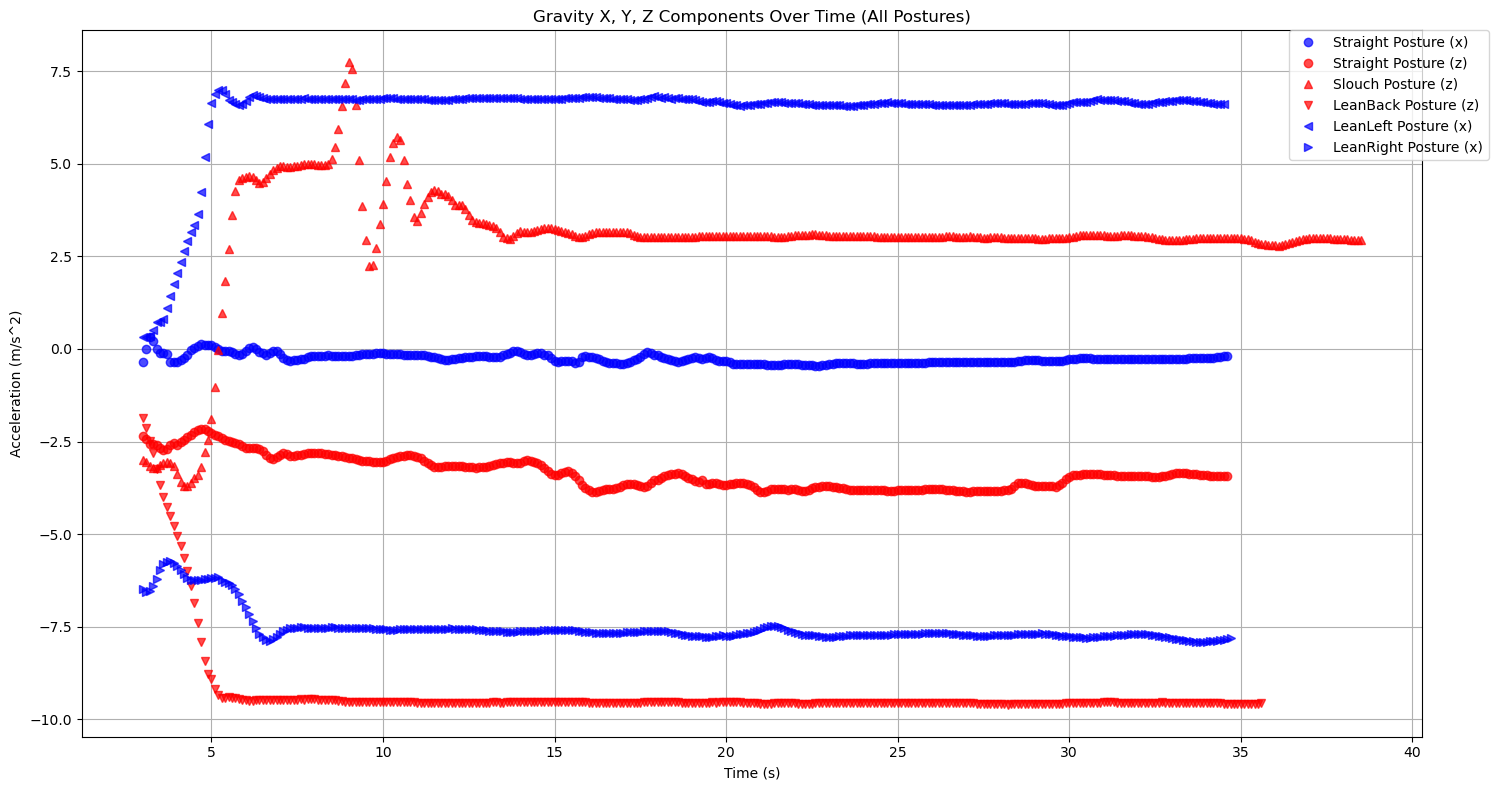

In [3]:
plt.figure(figsize=(15, 8))

lines = []
labels = []

gravity_cols = ['Acceleration x (m/s^2)', 'Acceleration z (m/s^2)']
colors = ['blue', 'red', 'green'] # Single set of colors for components

linestyles = {
    'straight': 'o',
    'slouch': '^',
    'leanback': 'v',
    'leanleft': '<',
    'leanright': '>'
}

# Plot for Straight Posture Gravity components
if 'df_gravity_bucketed' in bucketed_dataframes_straight:
    df_straight_gravity = bucketed_dataframes_straight['df_gravity_bucketed']
    for i, col in enumerate(gravity_cols):
        if col in df_straight_gravity.columns and not df_straight_gravity[col].empty:
            line, = plt.plot(df_straight_gravity['Time_Bucket'], df_straight_gravity[col], label=f'Straight Posture ({col.split(" ")[1]})', alpha=0.7, color=colors[i], marker=linestyles['straight'], linestyle='None')
            lines.append(line)
            labels.append(f'Straight Posture ({col.split(" ")[1]})')

# Plot for Slouch Posture Gravity components
if 'df_gravity_bucketed' in bucketed_dataframes_slouch:
    df_slouch_gravity = bucketed_dataframes_slouch['df_gravity_bucketed']
    for i, col in enumerate(gravity_cols):
        # Skip 'Acceleration x' for Slouch
        if col == 'Acceleration x (m/s^2)':
            continue
        if col in df_slouch_gravity.columns and not df_slouch_gravity[col].empty:
            line, = plt.plot(df_slouch_gravity['Time_Bucket'], df_slouch_gravity[col], label=f'Slouch Posture ({col.split(" ")[1]})', alpha=0.7, color=colors[i], marker=linestyles['slouch'], linestyle='None')
            lines.append(line)
            labels.append(f'Slouch Posture ({col.split(" ")[1]})')

# Plot for LeanBack Posture Gravity components
if 'df_gravity_bucketed' in bucketed_dataframes_leanback:
    df_leanback_gravity = bucketed_dataframes_leanback['df_gravity_bucketed']
    for i, col in enumerate(gravity_cols):
        # Skip 'Acceleration x' for LeanBack
        if col == 'Acceleration x (m/s^2)':
            continue
        if col in df_leanback_gravity.columns and not df_leanback_gravity[col].empty:
            line, = plt.plot(df_leanback_gravity['Time_Bucket'], df_leanback_gravity[col], label=f'LeanBack Posture ({col.split(" ")[1]})', alpha=0.7, color=colors[i], marker=linestyles['leanback'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanBack Posture ({col.split(" ")[1]})')

# Plot for LeanLeft Posture Gravity components
if 'df_gravity_bucketed' in bucketed_dataframes_leanleft:
    df_leanleft_gravity = bucketed_dataframes_leanleft['df_gravity_bucketed']
    for i, col in enumerate(gravity_cols):
        # Skip 'Acceleration y' and 'Acceleration z' for LeanLeft
        if col == 'Acceleration y (m/s^2)' or col == 'Acceleration z (m/s^2)':
            continue
        if col in df_leanleft_gravity.columns and not df_leanleft_gravity[col].empty:
            line, = plt.plot(df_leanleft_gravity['Time_Bucket'], df_leanleft_gravity[col], label=f'LeanLeft Posture ({col.split(" ")[1]})', alpha=0.7, color=colors[i], marker=linestyles['leanleft'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanLeft Posture ({col.split(" ")[1]})')

# Plot for LeanRight Posture Gravity components
if 'df_gravity_bucketed' in bucketed_dataframes_leanright:
    df_leanright_gravity = bucketed_dataframes_leanright['df_gravity_bucketed']
    for i, col in enumerate(gravity_cols):
        # Skip 'Acceleration y' and 'Acceleration z' for LeanRight
        if col == 'Acceleration y (m/s^2)' or col == 'Acceleration z (m/s^2)':
            continue
        if col in df_leanright_gravity.columns and not df_leanright_gravity[col].empty:
            line, = plt.plot(df_leanright_gravity['Time_Bucket'], df_leanright_gravity[col], label=f'LeanRight Posture ({col.split(" ")[1]})', alpha=0.7, color=colors[i], marker=linestyles['leanright'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanRight Posture ({col.split(" ")[1]})')

plt.title('Gravity X, Y, Z Components Over Time (All Postures)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
if lines:
    plt.legend(lines, labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing Orientation: Pitch Over Time (Straight vs. Slouch)
 Orientation: Roll, Pitch, Yaw, Direct Over Time (Straight vs. Slouch)

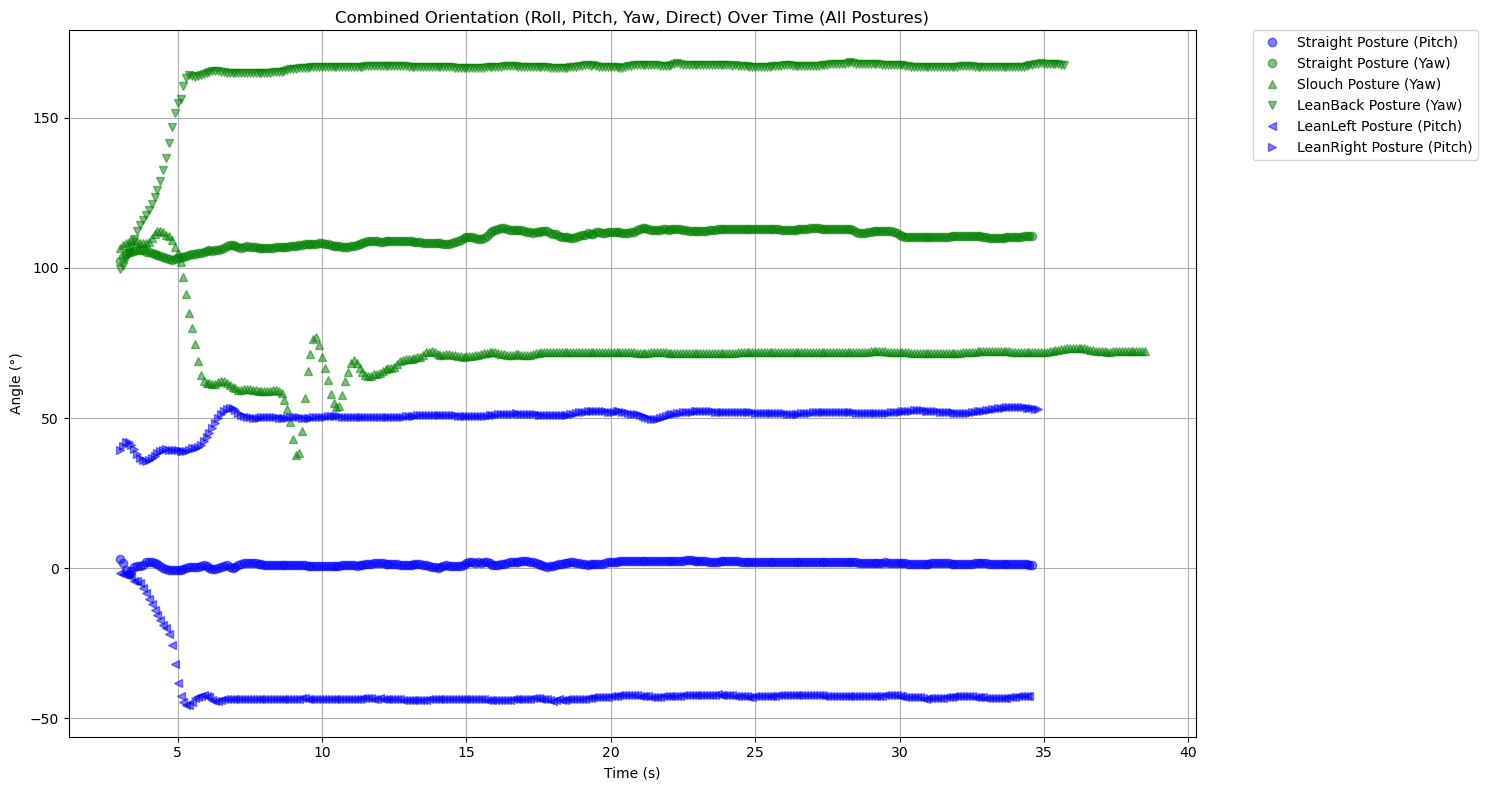

In [2]:
plt.figure(figsize=(15, 8))

lines = []
labels = []

orientation_cols = ['Pitch (°)', 'Yaw (°)']
colors = ['blue', 'green', 'purple', 'darkcyan'] # Single set of colors for components

linestyles = {
    'straight': 'o',
    'slouch': '^',
    'leanback': 'v',
    'leanleft': '<',
    'leanright': '>'
}

# Plot for Straight Posture Orientation components
if 'df_orientation_bucketed' in bucketed_dataframes_straight:
    df_straight_orientation = bucketed_dataframes_straight['df_orientation_bucketed']
    for i, col in enumerate(orientation_cols):
        if col in df_straight_orientation.columns and not df_straight_orientation[col].empty:
            line, = plt.plot(df_straight_orientation['Time_Bucket'], df_straight_orientation[col], label=f'Straight Posture ({col.split(" ")[0]})', alpha=0.5, color=colors[i], marker=linestyles['straight'], linestyle='None')
            lines.append(line)
            labels.append(f'Straight Posture ({col.split(" ")[0]})')

# Plot for Slouch Posture Orientation components
if 'df_orientation_bucketed' in bucketed_dataframes_slouch:
    df_slouch_orientation = bucketed_dataframes_slouch['df_orientation_bucketed']
    for i, col in enumerate(orientation_cols):
        # Exclude 'Pitch (°)' for Slouch
        if col == 'Pitch (°)':
            continue
        if col in df_slouch_orientation.columns and not df_slouch_orientation[col].empty:
            line, = plt.plot(df_slouch_orientation['Time_Bucket'], df_slouch_orientation[col], label=f'Slouch Posture ({col.split(" ")[0]})', alpha=0.5, color=colors[i], marker=linestyles['slouch'], linestyle='None')
            lines.append(line)
            labels.append(f'Slouch Posture ({col.split(" ")[0]})')

# Plot for LeanBack Posture Orientation components
if 'df_orientation_bucketed' in bucketed_dataframes_leanback:
    df_leanback_orientation = bucketed_dataframes_leanback['df_orientation_bucketed']
    for i, col in enumerate(orientation_cols):
        # Exclude 'Pitch (°)' for LeanBack
        if col == 'Pitch (°)':
            continue
        if col in df_leanback_orientation.columns and not df_leanback_orientation[col].empty:
            line, = plt.plot(df_leanback_orientation['Time_Bucket'], df_leanback_orientation[col], label=f'LeanBack Posture ({col.split(" ")[0]})', alpha=0.5, color=colors[i], marker=linestyles['leanback'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanBack Posture ({col.split(" ")[0]})')

# Plot for LeanLeft Posture Orientation components
if 'df_orientation_bucketed' in bucketed_dataframes_leanleft:
    df_leanleft_orientation = bucketed_dataframes_leanleft['df_orientation_bucketed']
    for i, col in enumerate(orientation_cols):
        # Exclude 'Yaw (°)' for LeanLeft
        if col == 'Yaw (°)':
            continue
        if col in df_leanleft_orientation.columns and not df_leanleft_orientation[col].empty:
            line, = plt.plot(df_leanleft_orientation['Time_Bucket'], df_leanleft_orientation[col], label=f'LeanLeft Posture ({col.split(" ")[0]})', alpha=0.5, color=colors[i], marker=linestyles['leanleft'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanLeft Posture ({col.split(" ")[0]})')

# Plot for LeanRight Posture Orientation components
if 'df_orientation_bucketed' in bucketed_dataframes_leanright:
    df_leanright_orientation = bucketed_dataframes_leanright['df_orientation_bucketed']
    for i, col in enumerate(orientation_cols):
        # Exclude 'Yaw (°)' for LeanRight
        if col == 'Yaw (°)':
            continue
        if col in df_leanright_orientation.columns and not df_leanright_orientation[col].empty:
            line, = plt.plot(df_leanright_orientation['Time_Bucket'], df_leanright_orientation[col], label=f'LeanRight Posture ({col.split(" ")[0]})', alpha=0.5, color=colors[i], marker=linestyles['leanright'], linestyle='None')
            lines.append(line)
            labels.append(f'LeanRight Posture ({col.split(" ")[0]})')

plt.title('Combined Orientation (Roll, Pitch, Yaw, Direct) Over Time (All Postures)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (°)')
if lines:
    plt.legend(lines, labels, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.) # Adjust legend position
plt.grid(True)
plt.tight_layout()
plt.show()


# Scaling

In [3]:
# --- 2. Scaling ---

# Hard-coded sensor envelopes sourced from device specs and IMU conventions
SENSOR_RANGES = {
    'df_accelerometer_bucketed': {
        'Acceleration x (m/s^2)': (-20.0, 20.0),
        'Acceleration y (m/s^2)': (-20.0, 20.0),
        'Acceleration z (m/s^2)': (-20.0, 20.0),
        'accelerometer_magnitude': (0.0, 35.0)
    },
    'df_gyroscope_bucketed': {
        'Gyroscope x (rad/s)': (-10.0, 10.0),
        'Gyroscope y (rad/s)': (-10.0, 10.0),
        'Gyroscope z (rad/s)': (-10.0, 10.0),
        'gyroscope_magnitude': (0.0, 18.0)
    },
    'df_gravity_bucketed': {
        'Acceleration x (m/s^2)': (-12.0, 12.0),
        'Acceleration y (m/s^2)': (-12.0, 12.0),
        'Acceleration z (m/s^2)': (-12.0, 12.0),
        'gravity_magnitude': (0.0, 21.0)
    },
    'df_orientation_bucketed': {
        'Pitch (°)': (-60.0, 60.0),
        'Roll (°)': (-180.0, 180.0),
        'Yaw (°)': (0.0, 100.0),
        'Direct (°)': (0.0, 360.0)
    }
}

per_feature_min_max = {
    f"{df_name}.{col}": {'min': min_val, 'max': max_val}
    for df_name, columns in SENSOR_RANGES.items()
    for col, (min_val, max_val) in columns.items()
}

def apply_min_max_scaling(df, df_name, feature_min_max):
    scaled_df = df.copy()
    for col in scaled_df.columns:
        if col == 'Time_Bucket' or not pd.api.types.is_numeric_dtype(scaled_df[col]):
            continue
        key = f"{df_name}.{col}"
        if key not in feature_min_max:
            continue
        col_min = feature_min_max[key]['min']
        col_max = feature_min_max[key]['max']
        col_range = col_max - col_min
        if col_range == 0:
            scaled_df[col] = 0.0
        else:
            scaled_df[col] = (scaled_df[col] - col_min) / col_range
    return scaled_df

scaled_bucketed_dataframes_straight = {key: apply_min_max_scaling(df, key, per_feature_min_max) for key, df in bucketed_dataframes_straight.items()}
scaled_bucketed_dataframes_slouch = {key: apply_min_max_scaling(df, key, per_feature_min_max) for key, df in bucketed_dataframes_slouch.items()}
scaled_bucketed_dataframes_leanback = {key: apply_min_max_scaling(df, key, per_feature_min_max) for key, df in bucketed_dataframes_leanback.items()}
scaled_bucketed_dataframes_leanleft = {key: apply_min_max_scaling(df, key, per_feature_min_max) for key, df in bucketed_dataframes_leanleft.items()}
scaled_bucketed_dataframes_leanright = {key: apply_min_max_scaling(df, key, per_feature_min_max) for key, df in bucketed_dataframes_leanright.items()}

# PCA

Fitted combined motion PCA -> 2 components (explained variance ratios: [0.48547011 0.44565208])


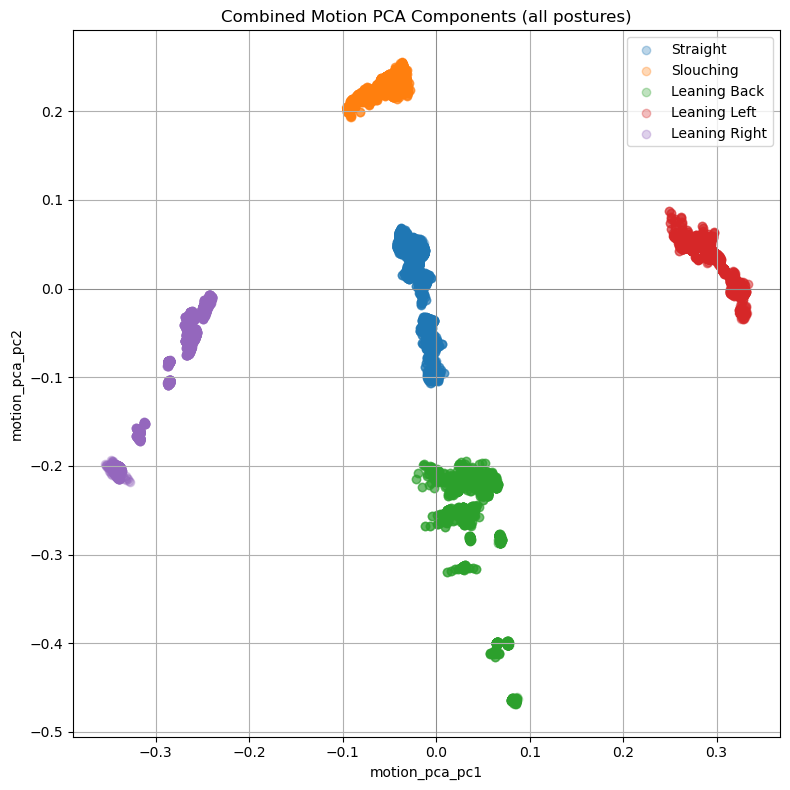

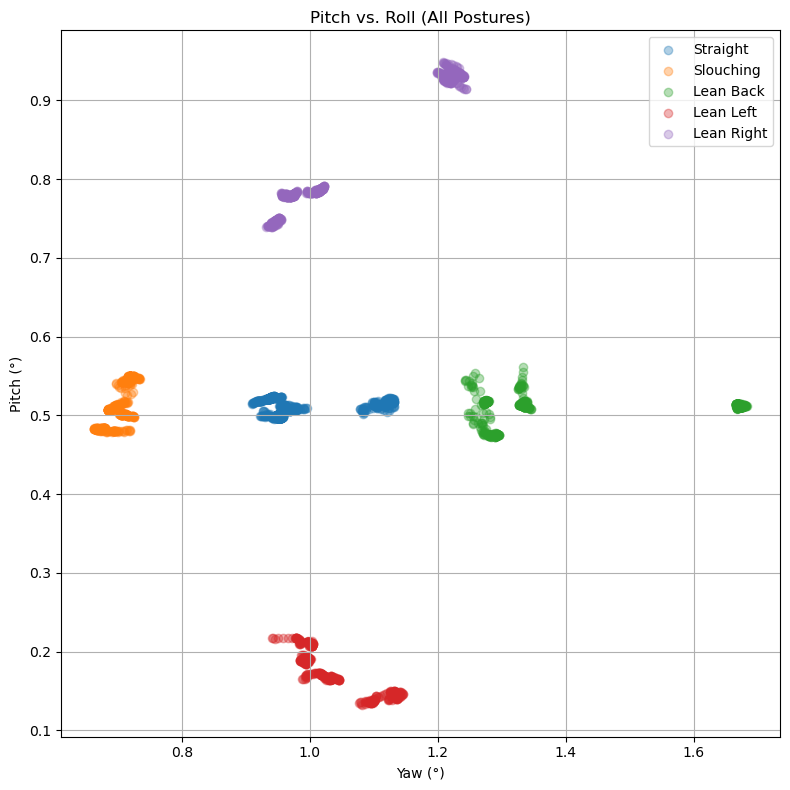

In [11]:
# --- 2b. PCA on Combined Motion Sensors + Orientation Filtering ---

motion_pca_sources = [
    ('df_accelerometer_bucketed', ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)']),
    ('df_gyroscope_bucketed', ['Gyroscope x (rad/s)', 'Gyroscope y (rad/s)', 'Gyroscope z (rad/s)']),
    ('df_gravity_bucketed', ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'])
]

motion_pca_prefix = 'motion_pca'
motion_pca_components = 2

training_posture_dicts = [
    scaled_bucketed_dataframes_straight,
    scaled_bucketed_dataframes_slouch,
    scaled_bucketed_dataframes_leanback,
    scaled_bucketed_dataframes_leanleft,
    scaled_bucketed_dataframes_leanright
]

trained_pca_models = {}
pca_export_bundle = {}

def _sanitize_motion_col(col_name):
    return (
        col_name.replace(' ', '_')
        .replace('(', '')
        .replace(')', '')
        .replace('°', 'deg')
        .replace('/', '_per_')
        .replace('^', 'pow')
    )

def build_motion_dataframe(posture_dict, sources):
    merged_df = None
    for df_key, cols in sources:
        if df_key not in posture_dict:
            return pd.DataFrame()
        df = posture_dict[df_key][['Time_Bucket'] + cols].copy()
        rename_map = {col: f"{df_key}_{_sanitize_motion_col(col)}" for col in cols}
        df.rename(columns=rename_map, inplace=True)
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.merge(df, on='Time_Bucket', how='inner')
    if merged_df is None or merged_df.empty:
        return pd.DataFrame()
    return merged_df

def stack_motion_training_data(posture_dicts, sources):
    frames = []
    for posture_dict in posture_dicts:
        combined_df = build_motion_dataframe(posture_dict, sources)
        if combined_df.empty:
            continue
        values = combined_df.drop(columns=['Time_Bucket']).copy()
        values = values.ffill().bfill().fillna(0.0)
        frames.append(values)
    if frames:
        return pd.concat(frames, ignore_index=True)
    return pd.DataFrame()

motion_training_values = stack_motion_training_data(training_posture_dicts, motion_pca_sources)

if motion_training_values.empty:
    print("Skipping motion PCA: insufficient data.")
else:
    n_components = min(motion_pca_components, motion_training_values.shape[1], len(motion_training_values))
    if n_components < 1:
        print("Skipping motion PCA: insufficient samples.")
    else:
        motion_pca_model = PCA(n_components=n_components, random_state=42)
        motion_pca_model.fit(motion_training_values)
        trained_pca_models['motion_pca'] = {
            'pca': motion_pca_model,
            'columns': list(motion_training_values.columns),
            'prefix': motion_pca_prefix
        }
        pca_export_bundle['motion_pca'] = {
            'columns': list(motion_training_values.columns),
            'components': motion_pca_model.components_.tolist(),
            'mean': motion_pca_model.mean_.tolist(),
            'prefix': motion_pca_prefix,
            'n_components': int(motion_pca_model.n_components_)
        }
        print(
            f"Fitted combined motion PCA -> {motion_pca_model.n_components_} components (explained variance ratios: {motion_pca_model.explained_variance_ratio_})"
        )

def apply_motion_pca_to_posture(posture_dict, pca_models, sources):
    if 'motion_pca' not in pca_models:
        return pd.DataFrame()
    motion_df = build_motion_dataframe(posture_dict, sources)
    if motion_df.empty:
        return pd.DataFrame()
    values = motion_df.drop(columns=['Time_Bucket']).copy()
    expected_cols = pca_models['motion_pca']['columns']
    missing_cols = [col for col in expected_cols if col not in values.columns]
    if missing_cols:
        return pd.DataFrame()
    values = values[expected_cols].ffill().bfill().fillna(0.0)
    pca_values = pca_models['motion_pca']['pca'].transform(values)
    result_df = pd.DataFrame({'Time_Bucket': motion_df['Time_Bucket']})
    for idx in range(pca_values.shape[1]):
        result_df[f"{pca_models['motion_pca']['prefix']}_pc{idx + 1}"] = pca_values[:, idx]
    return result_df

def apply_pca_and_orientation(posture_dict, pca_models, orientation_columns):
    transformed_dict = {}
    motion_pca_df = apply_motion_pca_to_posture(posture_dict, pca_models, motion_pca_sources)
    if not motion_pca_df.empty:
        transformed_dict['df_motion_pca'] = motion_pca_df
    if 'df_orientation_bucketed' in posture_dict:
        updated_df = posture_dict['df_orientation_bucketed'].copy()
        keep_cols = ['Time_Bucket'] + [col for col in orientation_columns if col in updated_df.columns]
        keep_cols = [col for col in keep_cols if col in updated_df.columns]
        if keep_cols:
            transformed_dict['df_orientation_bucketed'] = updated_df[keep_cols]
    return transformed_dict

orientation_features = ['Pitch (°)', 'Yaw (°)']

transformed_bucketed_dataframes_straight = apply_pca_and_orientation(scaled_bucketed_dataframes_straight, trained_pca_models, orientation_features)
transformed_bucketed_dataframes_slouch = apply_pca_and_orientation(scaled_bucketed_dataframes_slouch, trained_pca_models, orientation_features)
transformed_bucketed_dataframes_leanback = apply_pca_and_orientation(scaled_bucketed_dataframes_leanback, trained_pca_models, orientation_features)
transformed_bucketed_dataframes_leanleft = apply_pca_and_orientation(scaled_bucketed_dataframes_leanleft, trained_pca_models, orientation_features)
transformed_bucketed_dataframes_leanright = apply_pca_and_orientation(scaled_bucketed_dataframes_leanright, trained_pca_models, orientation_features)

# --- Diagnostic plot for the combined motion PCA ---
plt.figure(figsize=(8, 8))
posture_motion_sets = [
    ('straight', transformed_bucketed_dataframes_straight.get('df_motion_pca')),
    ('slouching', transformed_bucketed_dataframes_slouch.get('df_motion_pca')),
    ('leaning_back', transformed_bucketed_dataframes_leanback.get('df_motion_pca')),
    ('leaning_left', transformed_bucketed_dataframes_leanleft.get('df_motion_pca')),
    ('leaning_right', transformed_bucketed_dataframes_leanright.get('df_motion_pca'))
]
for label, df in posture_motion_sets:
    if df is None or df.empty:
        continue
    plt.scatter(
        df['motion_pca_pc1'],
        df['motion_pca_pc2'],
        alpha=0.3,
        label=label.replace('_', ' ').title()
    )
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlabel('motion_pca_pc1')
plt.ylabel('motion_pca_pc2')
plt.title('Combined Motion PCA Components (all postures)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
orientation_sets = [
    ("Straight", transformed_bucketed_dataframes_straight.get('df_orientation_bucketed')),
    ("Slouching", transformed_bucketed_dataframes_slouch.get('df_orientation_bucketed')),
    ("Lean Back", transformed_bucketed_dataframes_leanback.get('df_orientation_bucketed')),
    ("Lean Left", transformed_bucketed_dataframes_leanleft.get('df_orientation_bucketed')),
    ("Lean Right", transformed_bucketed_dataframes_leanright.get('df_orientation_bucketed'))
]
for label, df in orientation_sets:
    if df is None or df.empty or 'Pitch (°)' not in df.columns or 'Yaw (°)' not in df.columns:
        continue
    plt.scatter(
        df['Yaw (°)'],
        df['Pitch (°)'],
        alpha=0.35,
        label=label
    )
plt.xlabel('Yaw (°)')
plt.ylabel('Pitch (°)')
plt.title('Pitch vs. Roll (All Postures)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Extraction

In [6]:
# --- 3. Feature Extraction ---


def extract_features(dataframes_dict, window_size):
    features_list = []
    for df_name, df in dataframes_dict.items():
        temp_df = pd.DataFrame({'Time_Bucket': df['Time_Bucket']}).copy()
        numerical_cols = df.select_dtypes(include=np.number).columns.drop('Time_Bucket', errors='ignore')
        for col in numerical_cols:
            base_name = col.replace(' ', '_').replace('(', '').replace(')', '').replace('°', 'deg').replace('µ', 'micro')
            temp_df[f'{df_name}_{base_name}_mean'] = df[col].rolling(window=window_size).mean()
            temp_df[f'{df_name}_{base_name}_std'] = df[col].rolling(window=window_size).std()
        features_list.append(temp_df)


    if features_list:
        combined_features_df = reduce(lambda left, right: pd.merge(left, right, on='Time_Bucket', how='outer'), features_list)
    else:
        combined_features_df = pd.DataFrame(columns=['Time_Bucket'])
    combined_features_df.dropna(inplace=True)
    return combined_features_df


window_size = 4
features_straight_df = extract_features(transformed_bucketed_dataframes_straight, window_size)
features_slouch_df = extract_features(transformed_bucketed_dataframes_slouch, window_size)
features_leanback_df = extract_features(transformed_bucketed_dataframes_leanback, window_size)
features_leanleft_df = extract_features(transformed_bucketed_dataframes_leanleft, window_size)
features_leanright_df = extract_features(transformed_bucketed_dataframes_leanright, window_size)

# Training

In [7]:
# --- 4. Prepare Labeled Training Data ---

features_straight_df['posture'] = 'straight'
features_slouch_df['posture'] = 'slouching'
features_leanback_df['posture'] = 'leaning_back'
features_leanleft_df['posture'] = 'leaning_left'
features_leanright_df['posture'] = 'leaning_right'

combined_training_df = pd.concat([features_straight_df, features_slouch_df, features_leanback_df, features_leanleft_df, features_leanright_df], ignore_index=True)
X_train_df = combined_training_df.drop(columns=['Time_Bucket', 'posture'])
feature_columns = list(X_train_df.columns)
y_train_df = combined_training_df['posture']

# --- 5. Train Posture Classification Model ---

model = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=3,
    min_samples_split=4,
    n_estimators=300,
    random_state=42
)

model.fit(X_train_df, y_train_df)

scores = cross_val_score(model, X_train_df, y_train_df, cv=5)
print(scores.mean(), scores.std())

1.0 0.0


# Export

In [101]:
# Export to ONNX for Android integration

# Save necessary parameters for preprocessing and scaling
export_feature_min_max = {
    key: {'min': float(values['min']), 'max': float(values['max'])}
    for key, values in per_feature_min_max.items()
}
params = {
    'per_feature_min_max': export_feature_min_max,
    'window_size': int(window_size),
    'interval': 0.1,
    'trim_seconds': 3,
    'TIME_COL': 'Time (s)',
    'sheets_to_load': sheets_to_load,
    'class_labels': list(model.classes_),
    'feature_columns': feature_columns,
    'orientation_features': orientation_features,
    'pca': pca_export_bundle
}


with open('model_params.json', 'w') as f:
    json.dump(params, f)


print("Parameters exported successfully.")


try:
    # Define input shape (number of features)
    n_features = X_train_df.shape[1]
    initial_type = [('float_input', FloatTensorType([None, n_features]))]
    
    # Convert to ONNX
    onnx_model = convert_sklearn(model, initial_types=initial_type)
    
    # Save ONNX model
    with open("posture_model.onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    print("Model exported to ONNX successfully.")
except ImportError:
    print("skl2onnx not installed. Install with: pip install skl2onnx")

Parameters exported successfully.
Model exported to ONNX successfully.
Model exported to ONNX successfully.


# Testing

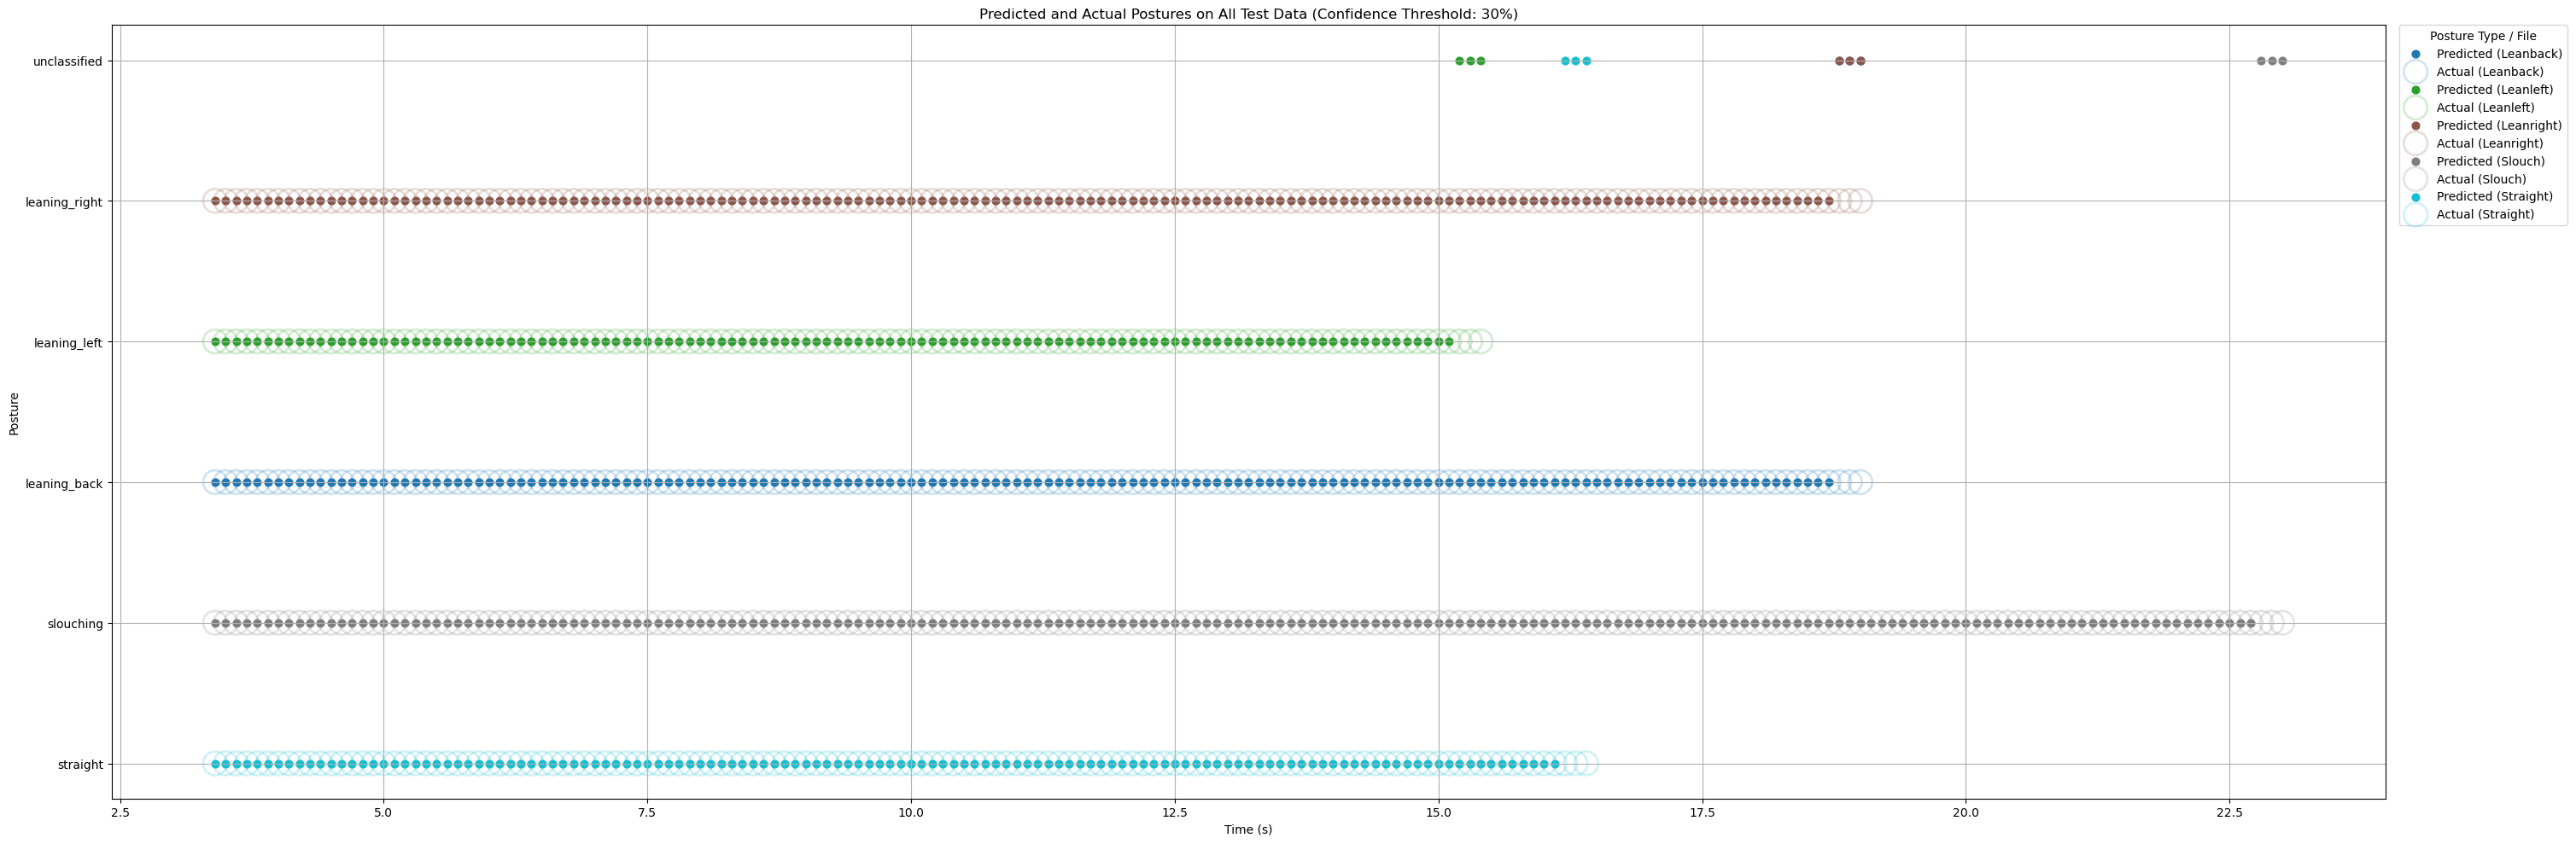

End-to-End Posture Detection Workflow Completed for all test files.


In [10]:
test_folder_path = 'Data/Test/Breejesh'
test_excel_file_paths = [os.path.join(test_folder_path, f) for f in os.listdir(test_folder_path) if f.endswith('.xls')]


all_test_results = []
confidence_threshold = 0.3  # Adjustable confidence threshold shared across plots


for file_path in test_excel_file_paths:
    # Determine actual posture from filename
    file_name = os.path.basename(file_path)
    # Example: 'LeanBack.xls' -> 'leaning_back'
    actual_posture_label = file_name.replace('.xls', '').lower().replace(' ', '_')
    # Handle 'Straight' case (original file name is 'Straight.xls', actual posture is 'straight')
    if actual_posture_label == 'straight':
        actual_posture_label = 'straight'
    elif actual_posture_label == 'leanback':
        actual_posture_label = 'leaning_back'
    elif actual_posture_label == 'leanleft':
        actual_posture_label = 'leaning_left'
    elif actual_posture_label == 'leanright':
        actual_posture_label = 'leaning_right'
    elif actual_posture_label == 'slouch':
        actual_posture_label = 'slouching'


    bucketed_dataframes_test = preprocess_sensor_data(file_path, sheets_to_load)
    scaled_bucketed_dataframes_test = {key: apply_min_max_scaling(df, key, per_feature_min_max) for key, df in bucketed_dataframes_test.items()}
    transformed_bucketed_dataframes_test = apply_pca_and_orientation(scaled_bucketed_dataframes_test, trained_pca_models, orientation_features)
    features_test_df = extract_features(transformed_bucketed_dataframes_test, window_size)


    if not features_test_df.empty:
        X_test = features_test_df.drop(columns=['Time_Bucket'])
        prediction_probabilities = model.predict_proba(X_test)


        current_test_results_df = pd.DataFrame({
            'Time_Bucket': features_test_df['Time_Bucket'],
            'Predicted_Posture': 'unclassified',  # Default to unclassified
            'File_Identifier': file_name # Add file identifier
        })


        class_labels = model.classes_


        for i, prob_array in enumerate(prediction_probabilities):
            max_prob_index = np.argmax(prob_array)
            max_prob = prob_array[max_prob_index]


            if max_prob >= confidence_threshold:
                current_test_results_df.loc[i, 'Predicted_Posture'] = class_labels[max_prob_index]
            else:
                current_test_results_df.loc[i, 'Predicted_Posture'] = 'unclassified'


        current_test_results_df['Actual_Posture'] = actual_posture_label
        all_test_results.append(current_test_results_df)



# Aggregate all test results into a single DataFrame
if all_test_results:
    combined_test_results_df = pd.concat(all_test_results, ignore_index=True)
else:
    combined_test_results_df = pd.DataFrame(columns=['Time_Bucket', 'Predicted_Posture', 'Actual_Posture', 'File_Identifier'])



# Map string labels to numerical values for plotting
posture_map_viz = {
    'straight': 0,
    'slouching': 1,
    'leaning_back': 2,
    'leaning_left': 3,
    'leaning_right': 4,
    'unclassified': 5
}
combined_test_results_df['Predicted_Posture_Numeric'] = combined_test_results_df['Predicted_Posture'].map(posture_map_viz)
combined_test_results_df['Actual_Posture_Numeric'] = combined_test_results_df['Actual_Posture'].map(posture_map_viz)





# --- Updated Plotting section for combined test results ---
plt.figure(figsize=(30, 10)) # Increased figure size for better readability


# Get unique file identifiers
unique_files = combined_test_results_df['File_Identifier'].unique()
# Filter out potential NaN from unique_files if any, as it causes issues with plotting
unique_files = [f for f in unique_files if pd.notna(f)]
num_files = len(unique_files)


# Use a colormap to get distinct colors for each file
# Using tab20 if there are up to 20 files, or tab10 if fewer.
# Removed incorrect import: import matplotlib.colormaps as cm
cmap = plt.get_cmap('tab10', num_files) # Corrected to use plt.get_cmap


# Plot Predicted and Actual for each file
for i, file_id in enumerate(unique_files):
    file_df = combined_test_results_df[combined_test_results_df['File_Identifier'] == file_id]
    color = cmap(i) # Get a unique color for this file


    if not file_df.empty:
        # Plot Predicted Postures for this file
        plt.scatter(
            file_df['Time_Bucket'],
            file_df['Predicted_Posture_Numeric'],
            color=color,
            marker='o',  # filled circle
            s=40,
            alpha=1,
            label=f'Predicted ({file_id.replace(".xls", "").replace("_", " ").title()})'
        )

        # Plot Actual Postures as hollow circles
        plt.scatter(
            file_df['Time_Bucket'],
            file_df['Actual_Posture_Numeric'],
            facecolors='none',  # hollow
            edgecolors=color,   # same color edge
            marker='o',         # hollow circle
            s=400,
            linewidth=2,
            alpha=0.2,
            label=f'Actual ({file_id.replace(".xls", "").replace("_", " ").title()})'
        )



plt.title(f'Predicted and Actual Postures on All Test Data (Confidence Threshold: {confidence_threshold*100:.0f}%)')
plt.xlabel('Time (s)')
plt.ylabel('Posture')
plt.yticks(ticks=list(posture_map_viz.values()), labels=list(posture_map_viz.keys()))


# Adjust legend placement to not overlap with the plot, increasing bbox_to_anchor for more space
plt.legend(title='Posture Type / File', loc='best', bbox_to_anchor=(1.08, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels/legend from overlapping
plt.show()


print("End-to-End Posture Detection Workflow Completed for all test files.")